In [1]:
import umap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from sklearn.preprocessing import StandardScaler

L_data = pd.read_excel('Properties_L.xlsx')
R_data = pd.read_excel('Properties_R.xlsx')
N_data = pd.read_excel('Properties_N.xlsx')

/home/xgx/miniconda3/envs/DailyUse/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
L_energy_map = L_data.set_index("fragment")["energy"].to_dict()
R_energy_map = R_data.set_index("fragment")["energy"].to_dict()
N_energy_map = N_data.set_index("fragment")["energy"].to_dict()

L_bv_map = L_data.set_index("fragment")["bv"].to_dict()
R_bv_map = R_data.set_index("fragment")["bv"].to_dict()
N_bv_map = N_data.set_index("fragment")["bv"].to_dict()

In [3]:
all_LRNs = list(product(L_data["fragment"].to_list(), R_data["fragment"].to_list(), N_data["fragment"].to_list()))
all_coms = pd.DataFrame(all_LRNs, columns=["Ligand", "Radical", "Nucleophile"])

In [4]:
train_Ls = ["DMEA-SA", "pyBOX", "R6-BOX", "bpy", "NNN"]
train_Rs = [
    "3-N",
    "3-COO",
    "2-iPr",
    "1-COO",
    "3-Ph",
    "2-COO",
    "2-Ph",
    "1-N",
    "1-Ph",
    "2-N",
]
train_Ns = ["PhC2H2", "CN", "PhC2", "Me", "Ph"]
train_LRNs = list(product(train_Ls, train_Rs, train_Ns))

In [5]:
train_coms = pd.DataFrame(train_LRNs, columns=["Ligand", "Radical", "Nucleophile"])
train_coms["Type"] = "Training Set"

In [6]:
test_coms = pd.read_excel("Merged_Coms_Valid.xlsx", header=0, index_col=[0,1,2]).reset_index()
test_coms["Type"] = "Test Set"

In [11]:
df_results = all_coms.merge(train_coms, on=["Ligand", "Radical", "Nucleophile"], how="left")
df_results = df_results.merge(test_coms, on=["Ligand", "Radical", "Nucleophile"], how="left")
df_results["Type"] = df_results["Type_x"].combine_first(df_results["Type_y"])
df_results = df_results.drop(["Type_x", "Type_y"], axis=1)

In [12]:
df_results["Type"].fillna("Other", inplace=True)

/tmp/ipykernel_2482751/1629001715.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_results["Type"].fillna("Other", inplace=True)


In [13]:
df_results["L_energy"] = df_results["Ligand"].replace(L_energy_map)
df_results["R_energy"] = df_results["Radical"].replace(R_energy_map)
df_results["N_energy"] = df_results["Nucleophile"].replace(N_energy_map)

df_results["L_bv"] = df_results["Ligand"].replace(L_bv_map)
df_results["R_bv"] = df_results["Radical"].replace(R_bv_map)
df_results["N_bv"] = df_results["Nucleophile"].replace(N_bv_map)

/tmp/ipykernel_2482751/2079446385.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_results["L_energy"] = df_results["Ligand"].replace(L_energy_map)
/tmp/ipykernel_2482751/2079446385.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_results["R_energy"] = df_results["Radical"].replace(R_energy_map)
/tmp/ipykernel_2482751/2079446385.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To 

In [14]:
df_results_other = df_results.loc[df_results["Type"] == "Other", :]
df_results_train = df_results.loc[df_results["Type"] == "Training Set", :]
df_results_test = df_results.loc[df_results["Type"] == "Test Set", :]

rs=2020
s=6000
rng = np.random.RandomState(rs)

arr = rng.choice(a=np.arange(len(df_results_other)), replace=False, size=s)
df_other = df_results_other.iloc[arr].reset_index(drop=True)
df_cut = pd.concat([df_other, df_results_train, df_results_test], ignore_index=True)

In [ ]:
features = ['L_energy', 'R_energy', 'N_energy', 'L_bv', 'R_bv', 'N_bv']
X = df_cut[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

reducer = umap.UMAP(
    n_components=3,
    n_jobs=1,
    n_neighbors=2,
    min_dist=0.3,
    random_state=rs,
    init="random",
)
umap_results = reducer.fit_transform(X_scaled)

df_cut['UMAP 1'] = umap_results[:, 0]
df_cut['UMAP 2'] = umap_results[:, 1]

In [16]:
df_cut

,Ligand,Radical,Nucleophile,Type,L_energy,R_energy,N_energy,L_bv,R_bv,N_bv,UMAP 1,UMAP 2
0,acac,2-O,Bn-p-Br,Other,-268.448564,-97.477326,26.813481,38.165785,58.934558,48.990614,1.105453,9.868146
1,phen,2-Ph-NCO,Bn,Other,-249.127547,-96.975318,40.097857,60.388111,69.991247,48.949642,2.232356,9.865255
2,BOPA,3-Ph-o-Cl,Py-o-Br,Other,-202.673018,-106.789567,7.894070,43.013446,79.058962,52.342819,4.703897,-0.538710
3,NNP-R5-R6,3-CN-tBu,Py-o-F,Other,-213.936814,-134.945918,24.127740,72.552890,82.561085,52.188245,9.137203,-2.805912
4,BOX-CN-R6,1-Ph-p-Br,tBu,Other,-247.734476,-118.291816,64.388750,41.481675,49.186159,71.221320,8.281242,5.040237
...,...,...,...,...,...,...,...,...,...,...,...,...
6312,R6-BOX,3-Ph-p-NMe2,Thio1-o-Ac,Test Set,-260.071312,-84.770258,6.802203,90.955565,77.484356,51.592297,8.911516,5.893318
6313,R6-BOX,3-quin,PhC2-p-F,Test Set,-260.071312,-108.182638,-8.678456,90.955565,76.794361,30.244338,8.724379,-0.227213
6314,TEMED,2-o-thiol,CF3C2,Test Set,-263.484964,-101.894993,-16.760779,74.096767,63.513111,30.008753,7.145200,0.197595
6315,TEMED,2-Ph-p-NMe2,CF3C2,Test Set,-263.484964,-86.834765,-16.760779,74.096767,64.151892,30.008753,0.920245,0.232927


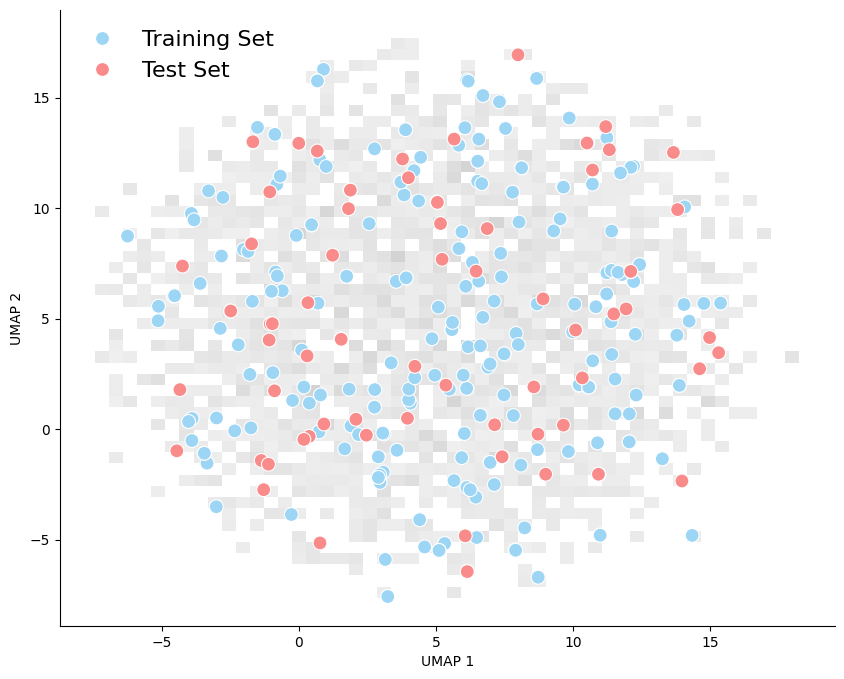

In [ ]:
palette = {"Training Set": "#9DD5F5", "Test Set": "#F98B8B"}

fig, ax = plt.subplots(figsize=(10, 8))

sns.histplot(
    data=df_cut.loc[df_cut["Type"] == "Other", :],
    x="UMAP 1",
    y="UMAP 2",
    color="#A4A4A4",
    bins=50,
    alpha=0.25,
    ax=ax,
)

sns.scatterplot(
    data=df_cut.loc[df_cut["Type"] != "Other", :],
    x="UMAP 1",
    y="UMAP 2",
    hue="Type",
    palette=palette,
    s=100,
    alpha=1,
    ax=ax,
)

ax.legend(frameon=False, title="", loc="upper left", fontsize=16)

sns.despine()

fig.savefig(f"UMAP_by_Property.png", dpi=500, bbox_inches="tight")

In [18]:
def draw_pictures(ax, rs: int, no: str):
    palette = {"Other": "#A4A4A4", "Training Set": "#9DD5F5", "Test Set": "#F98B8B"}

    features = ['L_energy', 'R_energy', 'N_energy', 'L_bv', 'R_bv', 'N_bv']
    X = df_cut[features].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    reducer = umap.UMAP(
        n_components=3,
        n_jobs=1,
        n_neighbors=2,
        min_dist=0.3,
        random_state=rs,
        init="random",
    )
    umap_results = reducer.fit_transform(X_scaled)

    df_cut['UMAP 1'] = umap_results[:, 0]
    df_cut['UMAP 2'] = umap_results[:, 1]

    sns.histplot(
        data=df_cut.loc[df_cut["Type"] == "Other", :],
        x="UMAP 1",
        y="UMAP 2",
        color="#A4A4A4",
        bins=50,
        alpha=0.25,
        ax=ax,
    )

    sns.scatterplot(
        data=df_cut.loc[df_cut["Type"] != "Other", :],
        x="UMAP 1",
        y="UMAP 2",
        hue="Type",
        palette=palette,
        s=75,
        alpha=1,
        ax=ax,
    )

    ax.set_title(f"Trial {rs//2020}", fontsize=16)
    ax.set_xlabel("")
    ax.set_ylabel("")

    if no > 0:
        ax.get_legend().remove()

    return ax

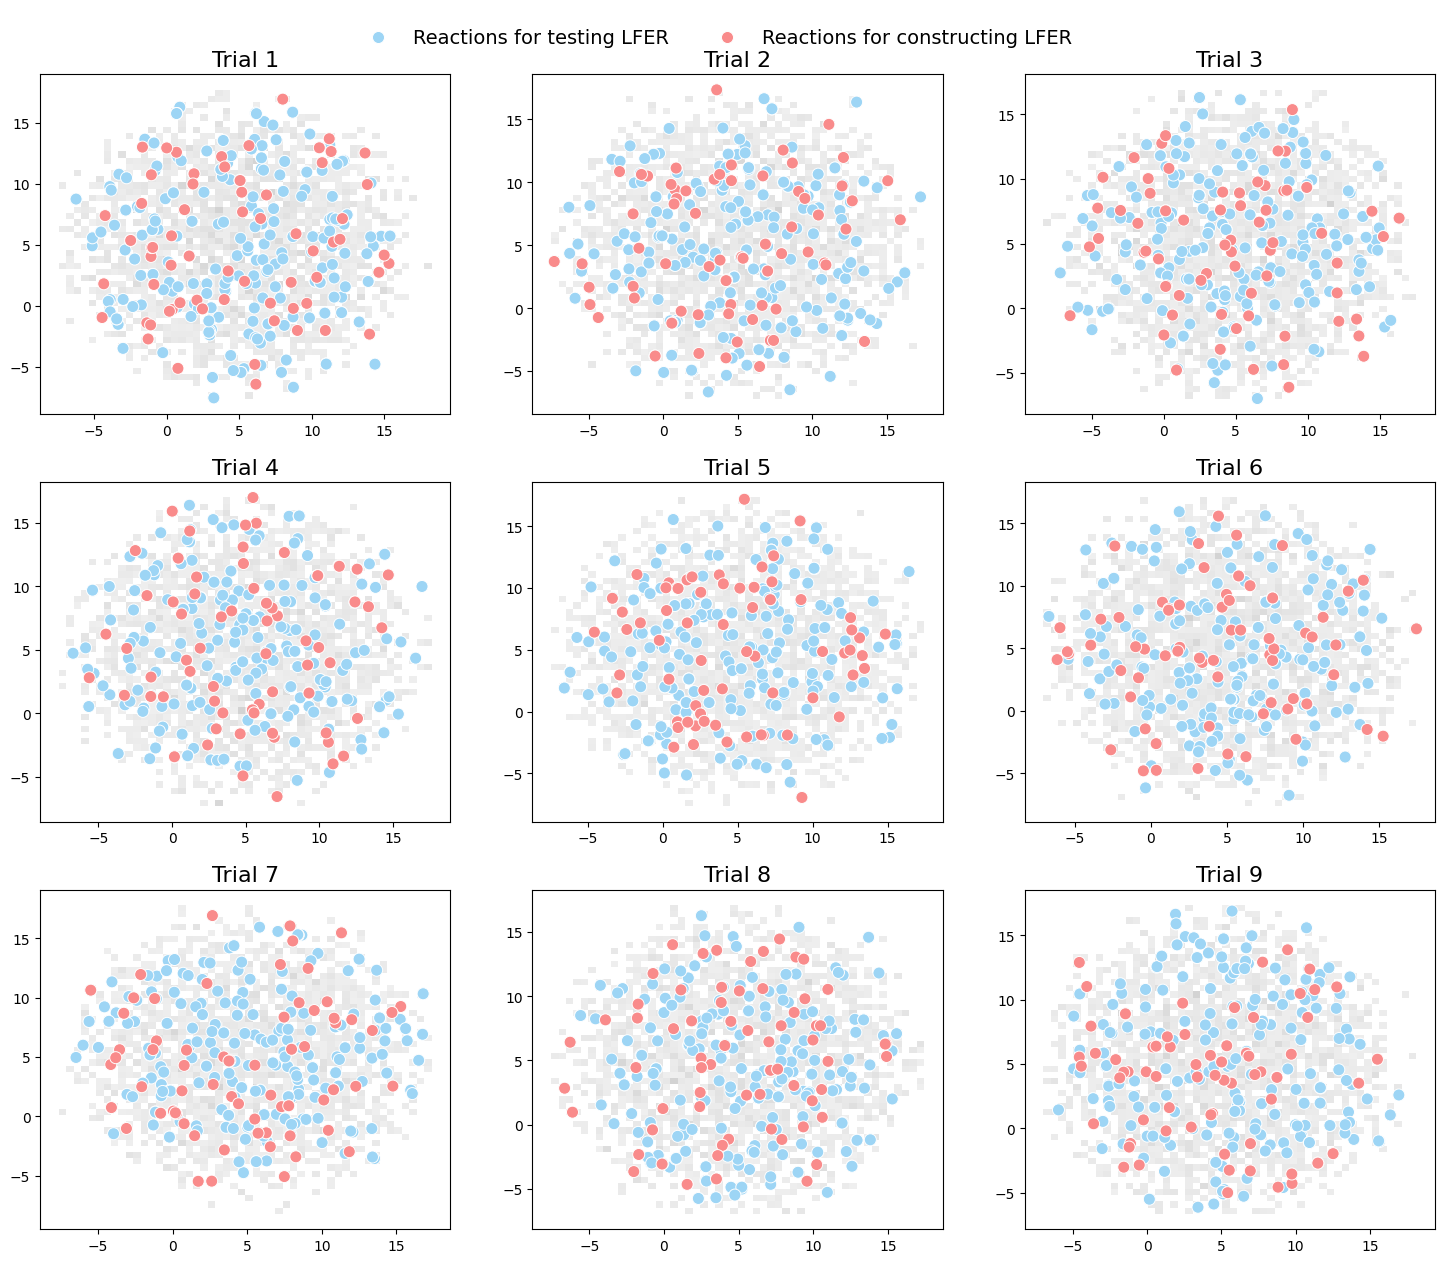

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

axes_flat = axes.flatten()

random_states = [2020 * (i + 1) for i in range(9)]
for i, (ax, state) in enumerate(zip(axes_flat, random_states)):
    draw_pictures(ax, rs=state, no=i)
    if ax.get_legend() is not None:
        ax.get_legend().remove()

handles, labels = axes_flat[0].get_legend_handles_labels()
labels = ["Reactions for testing LFER", "Reactions for constructing LFER"]
legend = fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=3,
    fontsize=14,
    bbox_to_anchor=(0.5, 0.93),
    frameon=False,
    fancybox=False,
    shadow=False,
    borderpad=1,
)

plt.savefig("UMAP_9_subplots_properties.png", dpi=500, bbox_inches="tight")
plt.show()